In [42]:
import openml
import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_percentage_error, roc_curve, roc_auc_score


In [2]:

dataset = openml.datasets.get_dataset(31)

X, y, categorical_indicator, attribute_names = dataset.get_data(target=dataset.default_target_attribute, dataset_format='dataframe')

df = X
categorical_columns = [i for i, indicator in enumerate(categorical_indicator) if indicator]

categorical_columns

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,1,6,1,6,1169.0,4,3,4,3,2,4,3,67,1,1,2,1,1,1,1
1,0,48,3,6,5951.0,2,0,2,0,2,2,3,22,1,1,1,1,1,0,1
2,3,12,1,2,2096.0,2,1,2,3,2,3,3,49,1,1,1,3,2,0,1
3,1,42,3,3,7882.0,2,1,2,3,1,4,1,45,1,0,1,1,2,0,1
4,1,24,2,4,4870.0,2,0,3,3,2,4,2,53,1,0,2,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,12,3,3,1736.0,2,1,3,0,2,4,3,31,1,1,1,3,1,0,1
996,1,30,3,9,3857.0,2,0,4,1,2,4,1,40,1,1,1,0,1,1,1
997,3,12,3,6,804.0,2,3,4,3,2,4,0,38,1,1,1,1,1,0,1
998,1,45,3,6,1845.0,2,0,4,3,2,4,2,23,1,0,1,1,1,1,1


In [ ]:
# Apply OneHotEncoder to categorical columns
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), categorical_columns)],
    remainder='passthrough'
)
df_encoded = pd.DataFrame(ct.fit_transform(df))

# Update column names after one-hot encoding
encoded_column_names = []
for i, indicator in enumerate(categorical_indicator):
    if indicator:
        categories = ct.transformers_[0][1].categories_[i]
        encoded_column_names.extend([f'{attribute_names[i]}_{category}' for category in categories])

df_encoded.columns = encoded_column_names

df_encoded

In [3]:
X = df_encoded
X

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,1,6,1,6,1169.0,4,3,4,3,2,4,3,67,1,1,2,1,1,1,1
1,0,48,3,6,5951.0,2,0,2,0,2,2,3,22,1,1,1,1,1,0,1
2,3,12,1,2,2096.0,2,1,2,3,2,3,3,49,1,1,1,3,2,0,1
3,1,42,3,3,7882.0,2,1,2,3,1,4,1,45,1,0,1,1,2,0,1
4,1,24,2,4,4870.0,2,0,3,3,2,4,2,53,1,0,2,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,12,3,3,1736.0,2,1,3,0,2,4,3,31,1,1,1,3,1,0,1
996,1,30,3,9,3857.0,2,0,4,1,2,4,1,40,1,1,1,0,1,1,1
997,3,12,3,6,804.0,2,3,4,3,2,4,0,38,1,1,1,1,1,0,1
998,1,45,3,6,1845.0,2,0,4,3,2,4,2,23,1,0,1,1,1,1,1


In [4]:
y

0      good
1       bad
2      good
3      good
4       bad
       ... 
995    good
996    good
997    good
998     bad
999    good
Name: class, Length: 1000, dtype: category
Categories (2, object): ['good' < 'bad']

In [5]:
y = y.replace({'good': 1, 'bad': 0})

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy: 0.8


### test model

In [11]:
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

accuracy = lgb_model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8


In [9]:
catboost_model = cb.CatBoostClassifier(verbose=False)
catboost_model.fit(X_train, y_train)

catboost_accuracy = catboost_model.score(X_test, y_test)
print("CatBoost Accuracy:", catboost_accuracy)


CatBoost Accuracy: 0.805


In [10]:
xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(X_train, y_train)

xgboost_accuracy = xgboost_model.score(X_test, y_test)
print("XGBoost Accuracy:", xgboost_accuracy)

XGBoost Accuracy: 0.835


### Set Hyperparameters as same

In [14]:
lgb_model_tuned = lgb.LGBMClassifier(learning_rate=0.05, n_estimators=1000, max_depth=10)
lgb_model_tuned.fit(X_train, y_train)

lgbm_accuracy = lgb_model_tuned.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8


In [40]:
cat_model_tuned = cb.CatBoostClassifier(learning_rate=0.05, n_estimators=1000, max_depth=10, verbose=False)
cat_model_tuned.fit(X_train, y_train)

catboost_accuracy_tuned = cat_model_tuned.score(X_test, y_test)
print("CatBoost Accuracy:", catboost_accuracy_tuned)


CatBoost Accuracy: 0.775


In [37]:
xgb_model_tuned = xgb.XGBClassifier(learning_rate=0.05, n_estimators=1000, max_depth=10)
xgb_model_tuned.fit(X_train, y_train)

xgb_accuracy_tuned = xgb_model_tuned.score(X_test, y_test)
print("XGBoost Accuracy:", xgb_accuracy_tuned)

XGBoost Accuracy: 0.81


### more detailed


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.63      0.65        59
           1       0.85      0.88      0.86       141

    accuracy                           0.81       200
   macro avg       0.77      0.75      0.76       200
weighted avg       0.80      0.81      0.80       200



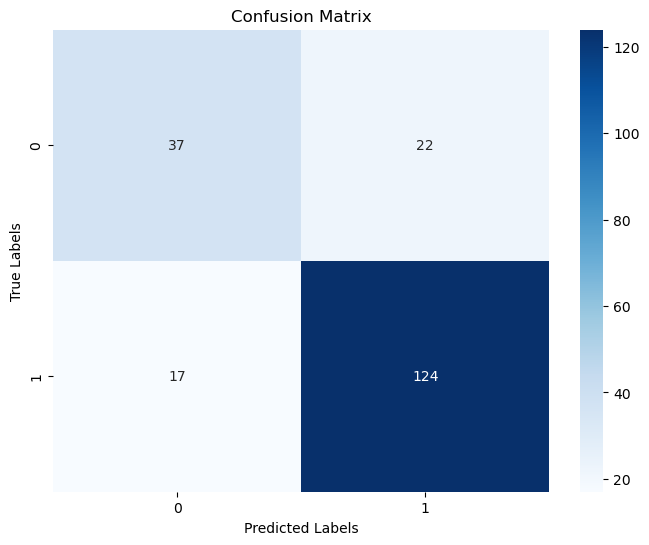

In [27]:
y_pred_lgbm = lgb_model_tuned.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm))

class_labels = np.unique(np.concatenate((y_test, y_pred_lgbm)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        59
           1       0.84      0.90      0.87       141

    accuracy                           0.81       200
   macro avg       0.78      0.75      0.76       200
weighted avg       0.80      0.81      0.80       200



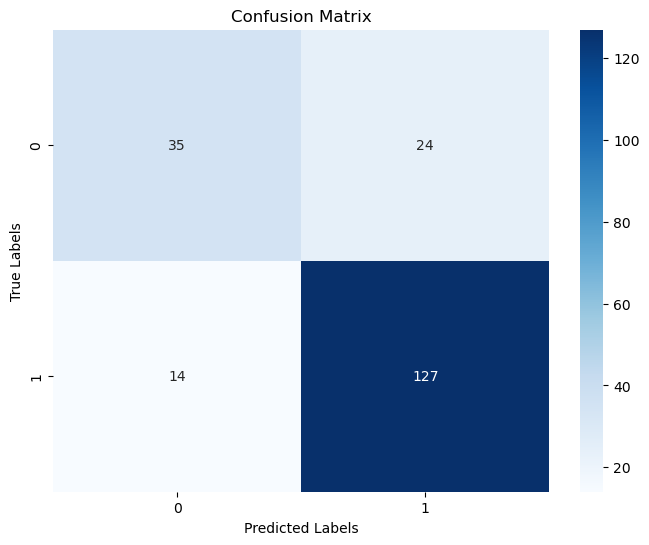

In [29]:
y_pred_xgb = xgb_model_tuned.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

class_labels = np.unique(np.concatenate((y_test, y_pred_xgb)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.42      0.53        59
           1       0.79      0.92      0.85       141

    accuracy                           0.78       200
   macro avg       0.74      0.67      0.69       200
weighted avg       0.76      0.78      0.76       200



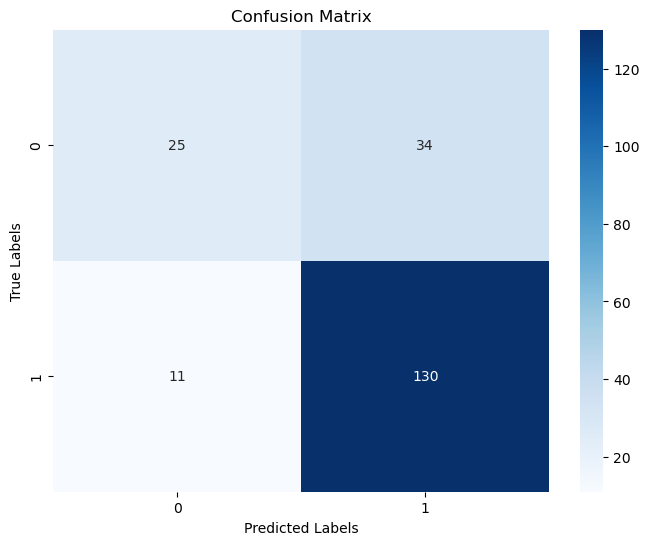

In [30]:
y_pred_cat = cat_model_tuned.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_cat))

class_labels = np.unique(np.concatenate((y_test, y_pred_cat)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [34]:
mape_lgbm = mean_absolute_percentage_error(y_test, y_pred_lgbm)
print("LGBM MAPE:", mape_lgbm)

mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
print("XGB MAPE:", mape_xgb)

mape_cat = mean_absolute_percentage_error(y_test, y_pred_cat)
print("CatBoost MAPE:", mape_cat)

LGBM MAPE: 495395959010754.56
XGB MAPE: 540431955284459.5
CatBoost MAPE: 765611936652984.4


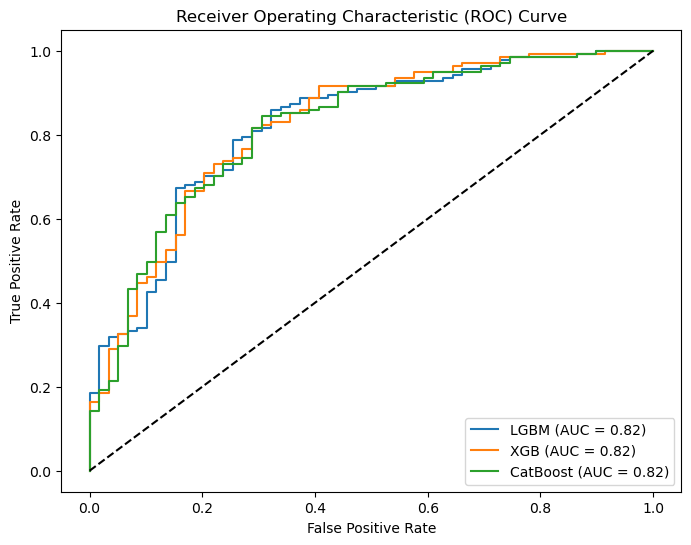

In [43]:
# Calculate predicted probabilities for each model
y_pred_proba_lgbm = lgb_model_tuned.predict_proba(X_test)[:, 1]
y_pred_proba_xgb = xgb_model_tuned.predict_proba(X_test)[:, 1]
y_pred_proba_cat = cat_model_tuned.predict_proba(X_test)[:, 1]

# Calculate false positive rate, true positive rate, and threshold values for ROC curve
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, y_pred_proba_lgbm)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_proba_xgb)
fpr_cat, tpr_cat, thresholds_cat = roc_curve(y_test, y_pred_proba_cat)

# Calculate AUC scores for each model
auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
auc_cat = roc_auc_score(y_test, y_pred_proba_cat)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, label='LGBM (AUC = {:.2f})'.format(auc_lgbm))
plt.plot(fpr_xgb, tpr_xgb, label='XGB (AUC = {:.2f})'.format(auc_xgb))
plt.plot(fpr_cat, tpr_cat, label='CatBoost (AUC = {:.2f})'.format(auc_cat))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()